#inputs and cleanup

data taken from https://www.kaggle.com/datasets/mandygu/lingspam-dataset

In [1]:
!pip -q install textstat dateparser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.4 MB/s eta 0:00:00


In [51]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import textstat
import pandas as pd
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import re
import dateparser
import spacy
from nltk.stem import WordNetLemmatizer

nlp = spacy.load("en_core_web_sm")

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.tag import pos_tag


df = pd.read_csv('messages.csv', sep=',')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
df.isnull().sum()

,0
subject,62
message,0
label,0


In [ ]:
len(df[(pd.isna(df['subject']))&(df['label'] == 1)])

13

In [ ]:
len(df[(pd.isna(df['subject']))&(df['label'] == 0)])

49

fill in with first word of the message and add full text column

In [52]:
stop = stopwords.words('english')

df['subject'] = df['subject'].fillna(df['message'].str.split().str[0])
df['text'] = df['subject'] + df['message']

In [54]:
from bs4 import BeautifulSoup

def extract_and_clean_html(text):
    if not isinstance(text, str):
        return ""

    match = re.search(r'Content-Type:\s*text/html;.*?\n\n(.*)', text, flags=re.DOTALL | re.IGNORECASE)
    if match:
        html = match.group(1)
        soup = BeautifulSoup(html, 'html.parser')
        text = soup.get_text(separator=' ', strip=True)
    return text

df['text_processed'] = df['text'].apply(extract_and_clean_html)

df['text_clean'] = (
    df['text_processed']
    .str.lower()
    .str.replace(r'https?://\S+', '', regex=True)                          # Remove URLs
    .str.replace(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '', regex=True)            # Remove email addresses
    .str.replace(r'\b(re|fwd)\s?:', '', regex=True)                        # Remove re: and fwd:
    .str.replace(r'^>.*$', '', regex=True)                                 # Remove quoted replies
    .str.replace(r'on .* wrote:', '', regex=True)                          # Remove reply headers
    .str.replace(r'<[^>]+>', ' ', regex=True)                              # Remove leftover HTML tags
    .str.replace(r'[^a-z0-9\s]', ' ', regex=True)                          # Remove non-alphanumerics
    .str.replace(r'\b\d+\b', ' ', regex=True)                              # Remove numbers
    .str.replace(r'\s+', ' ', regex=True)                                  # Normalize whitespace
    .str.strip()
)

lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

contractions = {
    "i'm": "i am",
    "can't": "cannot",
    "won't": "will not",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "they're": "they are",
    "we're": "we are",
    "you're": "you are",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not"
}

def expand_contractions(text):
    for contraction, full in contractions.items():
        text = re.sub(r"\b{}\b".format(re.escape(contraction)), full, text)
    return text

def replace_numbers(text):
    return re.sub(r'\b\d+%?\b', '<NUM>', text)

def replace_dates(text):
    return re.sub(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*[\s.,-]*\d{1,2}[\s.,-]*\d{2,4}\b', '<DATE>', text, flags=re.IGNORECASE)

def replace_named_entities(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'ORG', 'GPE']:
            tag = f"<{ent.label_}>"
            text = text.replace(ent.text, tag)
    return text

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    return ' '.join(lemmatized)

def normalize_email(text):
    text = text.lower()
    text = expand_contractions(text)
    text = replace_numbers(text)
    text = replace_dates(text)
    text = replace_named_entities(text)
    text = lemmatize_text(text)
    return text

df['text_normalized'] = df['text_clean'].apply(normalize_email)

In [55]:
df

,subject,message,label,text,text_processed,text_clean,text_normalized
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research centercontent...,job posting - apple-iss research centercontent...,job posting apple iss research centercontent l...,job post < ORG > length < ORG > a u million jo...
1,lang,"lang classification grimes , joseph e . and ba...",0,"langlang classification grimes , joseph e . an...","langlang classification grimes , joseph e . an...",langlang classification grimes joseph e and ba...,< GPE > classification grime joseph e and < PE...
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...,query : letter frequencies for text identifica...,query letter frequencies for text identificati...,query letter frequency for text identification...
3,risk,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...,riska colleague and i are researching the diff...,riska colleague and i are researching the diff...,< ORG > colleague and i be research the differ...
4,request book information,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...,request book informationearlier this morning i...,request book informationearlier this morning i...,request book informationearlier this morning i...
...,...,...,...,...,...,...,...
2888,love your profile - ysuolvpv,hello thanks for stopping by ! ! we have taken...,1,love your profile - ysuolvpvhello thanks for s...,love your profile - ysuolvpvhello thanks for s...,love your profile ysuolvpvhello thanks for sto...,love your profile ysuolvpvhello thanks for sto...
2889,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1,you have been asked to join kiddinthe list own...,you have been asked to join kiddinthe list own...,you have been asked to join kiddinthe list own...,you have be ask to join < ORG > the list owner...
2890,anglicization of composers ' names,"judging from the return post , i must have sou...",0,anglicization of composers ' namesjudging from...,anglicization of composers ' namesjudging from...,anglicization of composers namesjudging from t...,anglicization of composer namesjudging from th...
2891,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0,"re : 6 . 797 , comparative method : n - ary co...","re : 6 . 797 , comparative method : n - ary co...",comparative method n ary comparisongotcha ther...,comparative method n ary comparisongotcha ther...


In [56]:
df = df[['label', 'text_normalized']]

In [57]:
df

,label,text_normalized
0,0,job post < ORG > length < ORG > a u million jo...
1,0,< GPE > classification grime joseph e and < PE...
2,0,query letter frequency for text identification...
3,0,< ORG > colleague and i be research the differ...
4,0,request book informationearlier this morning i...
...,...,...
2888,1,love your profile ysuolvpvhello thanks for sto...
2889,1,you have be ask to join < ORG > the list owner...
2890,0,anglicization of composer namesjudging from th...
2891,0,comparative method n ary comparisongotcha ther...


#Additional data

In [58]:
import zipfile
with zipfile.ZipFile('archive (3).zip', 'r') as zip_ref:
    zip_ref.extractall('new_data')

In [59]:
def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path+file, encoding = "ISO-8859-1")
        words_list = f.read()
        data.append(words_list)
        f.close()
    return data

easy_ham = get_data('new_data/easy_ham/easy_ham/')
hard_ham = get_data('new_data/hard_ham/hard_ham/')
ham = easy_ham + hard_ham
spam = get_data('new_data/spam_2/spam_2/')

In [ ]:
len(ham), len(spam)

(2801, 1397)

In [60]:
df1 = pd.DataFrame(ham + spam, columns=['text'])

In [61]:
df1['text_processed'] = df1['text'].apply(extract_and_clean_html)

df1['text_clean'] = (
    df1['text_processed']
    .str.lower()
    .str.replace(r'https?://\S+', '', regex=True)                          # Remove URLs
    .str.replace(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '', regex=True)            # Remove email addresses
    .str.replace(r'\b(re|fwd)\s?:', '', regex=True)                        # Remove re: and fwd:
    .str.replace(r'^>.*$', '', regex=True)                                 # Remove quoted replies
    .str.replace(r'on .* wrote:', '', regex=True)                          # Remove reply headers
    .str.replace(r'<[^>]+>', ' ', regex=True)                              # Remove leftover HTML tags
    .str.replace(r'[^a-z0-9\s]', ' ', regex=True)                          # Remove non-alphanumerics
    .str.replace(r'\b\d+\b', ' ', regex=True)                              # Remove numbers
    .str.replace(r'\s+', ' ', regex=True)                                  # Normalize whitespace
    .str.strip()
)

In [62]:
df1['text_normalized'] = df1['text_clean'].apply(normalize_email)

In [63]:
df1['label'] = [0] * len(ham) + [1] * len(spam)

In [64]:
df1 = df1[['label', 'text_normalized']]

In [65]:
df_full = pd.concat([df, df1], axis=0)

In [66]:
df_full

,label,text_normalized
0,0,job post < ORG > length < ORG > a u million jo...
1,0,< GPE > classification grime joseph e and < PE...
2,0,query letter frequency for text identification...
3,0,< ORG > colleague and i be research the differ...
4,0,request book informationearlier this morning i...
...,...,...
4193,1,tremendous saving on toner inkjets fax and the...
4194,1,hi have you be pay too much for your home or b...
4195,1,gt toner supply laser printer and computer sup...
4196,1,online credit breakthrough repair your credit ...


#EDA

look at class imbalance:

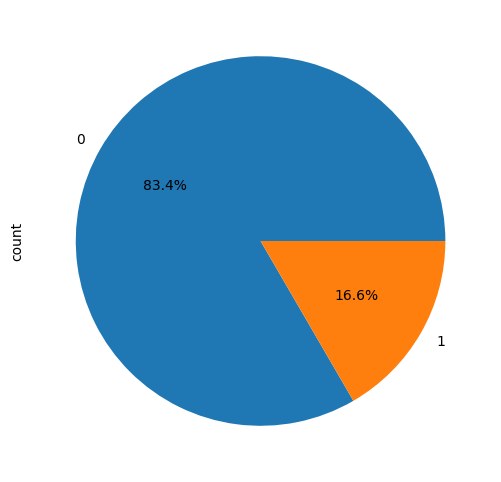

In [ ]:
counts = df['label'].value_counts()

counts.plot.pie(autopct='%1.1f%%', figsize=(6, 6))
plt.show()

classes are very imbalanced - we will have to do something

some spam mail:

In [ ]:
df[df['label'] == 1]['message'][:5]

,message
21,this is a multi-part message in mime format . ...
38,note : we do not wish to send e-mail to anyone...
84,"just released . . . 30 , 000 , 000 email addre..."
85,"hi , would you like to earn an extra $ 700 a w..."
86,this is really cool ! premium channels and pay...


and normal mail:

In [ ]:
df[df['label'] == 0]['message'][:5]

,message
0,content - length : 3386 apple-iss research cen...
1,"lang classification grimes , joseph e . and ba..."
2,i am posting this inquiry for sergei atamas ( ...
3,a colleague and i are researching the differin...
4,earlier this morning i was on the phone with a...


simple tokenizing and cosine similarity test

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['tokenized_text'])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

cos_sim = cosine_similarity(X)

clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.5,
    linkage='average'
)
labels = clustering.fit_predict(1 - cos_sim)

df['cluster'] = labels

In [ ]:
df['cluster'].value_counts()[:10].index

Index([1, 59, 0, 39, 29, 191, 31, 35, 12, 64], dtype='int64', name='cluster')

In [ ]:
df[df['cluster'] == 1][['tokenized_text', 'text', 'label']]

,tokenized_text,text,label
138,hi spam name matthew make habit deleting mail ...,hi this is not spam my name is matthew ...,1
278,hi spam name matthew make habit deleting mail ...,hi this is not spam my name is matthew ...,1
354,see thisi never thought one telling actually r...,you have to see thisi never thought i d be the...,1
671,extra holiday never thought one telling actual...,extra holiday i never thought i d be the o...,1
678,move bill gates subject move bill gates legal ...,move over bill gates subject move over...,1
942,please read wont regret research indicates fol...,please read you wont regret it our research i...,1
1118,success guaranteed research indicates followin...,success guaranteed our research indicates th...,1
1739,incredible opportunitydear friend received mes...,incredible opportunitydear friend if you rece...,1
1796,hard work nt pass time selected receive email ...,no hard work do nt pass it by this tim...,1
1957,home computer workers needed personal advise s...,home computer workers needed now my pe...,1


In [ ]:
df[df['cluster'] == 59][['text', 'label']]

,text,label
1081,last chanceif you wish to be removed reply wi...,1
1753,re the virtual girlfriend and virtual boyfrien...,1
1961,hello there this really is a blast with all ...,1
2492,re the virtual girlfriend and virtual boyfri...,1
2529,re the virtual girlfriend and virtual boyfrien...,1
2559,re the virtual girlfriend and virtual boyfri...,1
2575,re the virtual girlfriend and virtual boyfri...,1
2598,re the virtual girlfriend and virtual boyfri...,1


In [ ]:
df[df['cluster'] == 35][['text', 'label']]

,text,label
1480,press release cd vol online business go...,1
1678,now available cd vol press release our late...,1
2626,just released cd vol aonline business got yo...,1
2704,our latest greatest cd vol aonline business...,1


actually, gave rather good results - popular clusters are rather homogenous. Let's check how all are faring:

In [ ]:
cluster_sizes = df.groupby('cluster').size()
df1 = cluster_sizes[cluster_sizes == 2].index

label_means = df[df['cluster'].isin(df1)].groupby('cluster')['label'].mean()

label_means[(label_means != 0) & (label_means != 1)]

,label
cluster,


also, we do not remove things like https or re on purpose - they may be useful

#new EDA

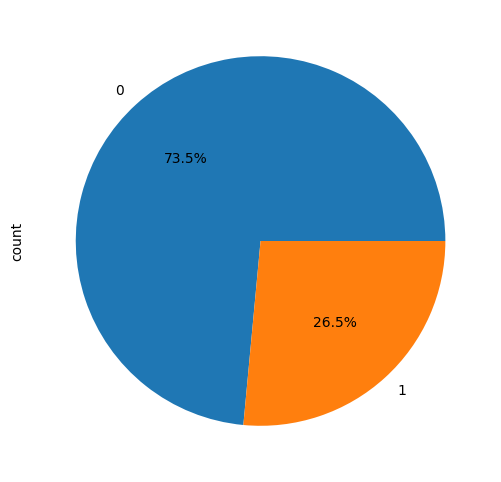

In [ ]:
counts = df_full['label'].value_counts()

counts.plot.pie(autopct='%1.1f%%', figsize=(6, 6))
plt.show()

In [ ]:
df_full[df_full['label'] == 1]['text_normalized'][:5]

,text_normalized
21,freethis is a multi part message in mime forma...
38,the internet success toolboxnote we do not wis...
84,< ORG > bulk email software just released emai...
85,need more money hi would you like to earn an e...
86,cable decsrambler now only this is really cool...


In [ ]:
df_full[df_full['label'] == 0]['text_normalized'][:5]

,text_normalized
0,job posting < ORG > length < ORG > a u million...
1,< GPE > classification grime joseph e and < PE...
2,query letter frequency for text identification...
3,< ORG > colleague and i are researching the di...
4,request book informationearlier this morning i...


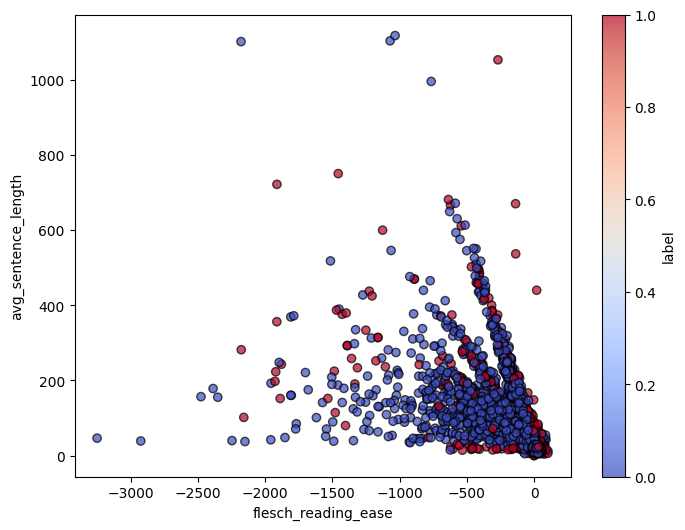

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train['flesch_reading_ease'], X_train['avg_sentence_length'], c=y_train, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.xlabel("flesch_reading_ease")
plt.ylabel("avg_sentence_length")
plt.colorbar(label="label")
plt.show()

In [ ]:
import numpy as np

In [ ]:
corr_matrix = X_train_combined.corr(numeric_only=True)

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if abs(upper.loc[row, col]) > 0.8
]
high_corr_pairs

[(223, 127, np.float64(-0.9813706389627923))]

weird... completely negatively correlated pair of vector components generated by BERT

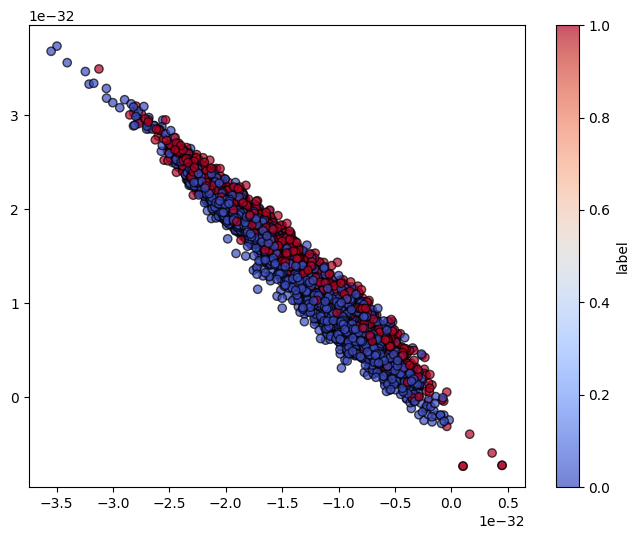

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_combined.iloc[:, 223], X_train_combined.iloc[:, 127], c=y_train, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.colorbar(label="label")
plt.show()

In [ ]:
corr_matrix = X_train_combined.corr(numeric_only=True)

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if abs(upper.loc[row, col]) > 0.75
]
high_corr_pairs

[(223, 127, np.float64(-0.9813706389627923)),
 (325, 261, np.float64(0.7524592567760993)),
 (351, 28, np.float64(0.7763604515008039))]

In [ ]:
corr_matrix = X_train_combined.corr(numeric_only=True)

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if abs(upper.loc[row, col]) > 0.7
]
len(high_corr_pairs)

21

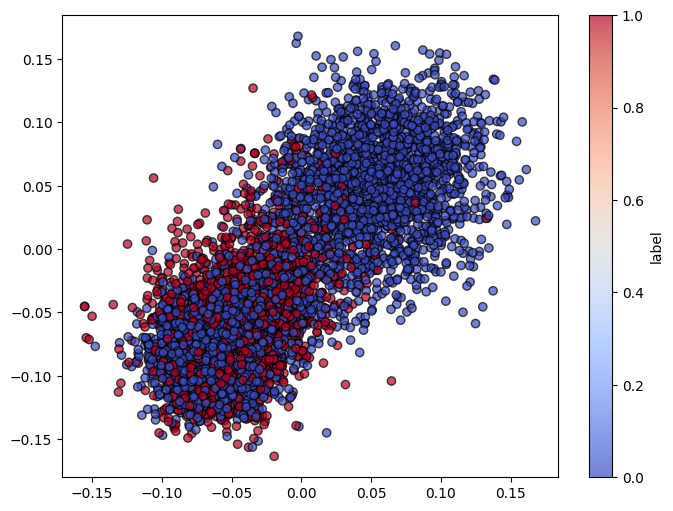

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_combined.iloc[:, 351], X_train_combined.iloc[:, 28], c=y_train, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.colorbar(label="label")
plt.show()

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=2e-3)
X_selected = pd.DataFrame(selector.fit_transform(X_train_combined.iloc[:, :384]))
X_selected

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,-0.069905,-0.009923,0.004512,0.014891,-0.109022,-0.099951,0.016984,-0.015465,-0.058281,-0.020032,...,-0.004848,-0.131467,-0.043538,0.009773,-0.033147,0.028213,0.042397,-0.064804,0.092410,0.062614
1,-0.045666,-0.088899,-0.035873,0.043264,-0.062382,-0.084438,0.020733,-0.035018,-0.053056,-0.100740,...,-0.072711,-0.019901,-0.051957,0.047958,-0.057116,-0.071582,-0.033100,-0.040615,0.026749,-0.045211
2,-0.064111,-0.013094,-0.061067,-0.022950,-0.061884,-0.088111,0.046609,-0.004322,-0.050643,-0.099074,...,-0.070348,-0.112630,-0.074599,0.007511,-0.041280,0.061744,0.053326,0.034080,0.049619,-0.011446
3,-0.022164,-0.029847,-0.025371,0.051810,-0.067131,-0.077814,0.046188,-0.000036,-0.012230,-0.050552,...,-0.042331,-0.055213,-0.105383,0.089962,-0.073752,-0.002045,-0.014160,-0.007688,0.086163,-0.030007
4,-0.056448,-0.022439,-0.045615,-0.011148,-0.114679,-0.036395,0.063730,0.010073,-0.051156,-0.075155,...,-0.097414,-0.086247,-0.060672,0.040322,-0.082437,-0.011801,0.003719,-0.044411,0.097208,0.035072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6376,0.062601,-0.016783,0.010215,-0.041780,0.093836,-0.006479,-0.056823,-0.021370,-0.095870,-0.147583,...,-0.015752,0.020088,-0.098216,-0.046080,0.104979,-0.021437,0.069095,0.016092,0.005160,-0.018638
6377,-0.096213,-0.051000,-0.046669,0.006071,-0.077625,-0.060794,0.081819,-0.025318,-0.046841,0.006503,...,-0.071760,-0.061625,-0.099543,0.029162,-0.056401,-0.043467,0.011110,-0.049894,0.100994,-0.001908
6378,-0.080735,-0.022407,-0.053411,0.027348,-0.067203,-0.082155,0.052754,0.004132,-0.049993,-0.060264,...,-0.074317,-0.087027,-0.118646,0.046928,-0.053763,0.029860,0.026308,-0.057669,0.095132,0.037153
6379,0.000637,0.071125,-0.076893,0.003431,0.023169,-0.007404,0.083066,0.022956,-0.017930,-0.057898,...,0.007596,-0.082314,-0.048933,0.121186,-0.110553,-0.001310,-0.042462,0.072141,-0.024886,-0.059093


In [ ]:
corr_matrix = X_selected.corr(numeric_only=True)

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if abs(upper.loc[row, col]) > 0.7
]
len(high_corr_pairs)

15

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=382)
X_pca = pca.fit_transform(X_train_combined.iloc[:, :384])
X_pca = pd.DataFrame(X_pca)

corr_matrix = X_pca.corr(numeric_only=True)

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if abs(upper.loc[row, col]) > 0.5
]
print(len(high_corr_pairs))
high_corr_pairs[:5]

0


[]

# Classification

##data split and vectorize

In [68]:
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

X = df_full.drop(['label'], axis=1)
y = df_full['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [69]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_train = model.encode(X_train['text_normalized'].values)
embeddings_test = model.encode(X_test['text_normalized'].values)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [70]:
X_vec_train = pd.DataFrame(embeddings_train)
X_vec_test = pd.DataFrame(embeddings_test)

numeric_cols = [col for col in X.columns if col != 'text_normalized']
X_train_numeric = X_train[numeric_cols].reset_index(drop=True)
X_test_numeric = X_test[numeric_cols].reset_index(drop=True)

X_train_combined = pd.concat([X_vec_train, X_train_numeric], axis=1)
X_test_combined = pd.concat([X_vec_test, X_test_numeric], axis=1)

/tmp/ipython-input-971969165.py:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  X_train_combined = pd.concat([X_vec_train, X_train_numeric], axis=1)
/tmp/ipython-input-971969165.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  X_test_combined = pd.concat([X_vec_test, X_test_numeric], axis=1)


In [ ]:
X_train_combined.shape, X_test_combined.shape, y_train.shape, y_test.shape

((6381, 387), (710, 387), (6381,), (710,))

##logreg

In [ ]:
X_test_combined

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,flesch_reading_ease,avg_sentence_length
0,-0.004491,-0.019150,0.018518,-0.030963,-0.048611,-0.068103,0.031420,-0.049170,-0.022925,0.002417,...,-0.031135,-0.054058,0.070716,-0.002404,0.030422,0.013548,-0.024792,0.030084,25.176476,8.441860
1,-0.025257,0.039514,0.046941,-0.011731,-0.040941,-0.048217,0.003749,-0.000291,-0.011560,0.005433,...,-0.030001,-0.033539,0.116880,0.062125,0.017689,0.014309,0.007984,-0.015551,23.998757,32.244444
2,-0.037681,-0.067226,0.026879,-0.006763,0.010728,-0.023693,0.017418,-0.010451,-0.011583,0.040266,...,0.001456,0.019299,0.082060,0.019087,0.080724,-0.001806,-0.020454,-0.013050,-171.498529,63.000000
3,-0.028359,-0.031801,-0.003641,-0.015922,-0.005381,-0.088363,0.060092,-0.020469,0.012621,0.039125,...,-0.051588,-0.058637,0.090853,0.041981,0.000602,0.036495,0.009042,0.011360,13.871347,19.297297
4,0.035913,-0.007200,0.016677,0.013208,0.026311,0.057525,0.099684,0.057595,0.055630,0.114475,...,0.002098,0.042156,-0.110736,-0.020205,0.071910,0.062317,0.081714,-0.011346,-127.969735,58.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,-0.045001,0.015285,0.003038,-0.039130,-0.035869,-0.053769,0.058619,-0.052907,0.000141,0.061529,...,-0.047621,-0.031922,0.107464,0.058052,-0.012190,0.056099,-0.039550,-0.004622,9.773884,9.202899
706,-0.031094,-0.039668,0.041139,0.020578,0.063037,-0.047826,0.065145,-0.031947,-0.089964,0.015420,...,0.007382,0.004445,0.078940,0.075603,0.074796,-0.021273,-0.083988,-0.018686,21.041077,12.305556
707,-0.047006,0.059018,0.010756,0.002456,-0.018784,-0.070488,0.018010,0.007488,0.004982,0.036494,...,-0.036969,-0.059228,0.118442,0.050013,0.025029,0.032212,0.017578,-0.012678,36.872138,14.329412
708,-0.014697,0.038091,0.024896,-0.023432,-0.056210,0.053191,0.039717,-0.004751,0.036922,0.010513,...,0.010408,0.072278,0.042912,0.059244,0.034457,-0.172202,0.025943,-0.006767,23.890417,14.937500


In [92]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_combined.to_numpy(), y_train)

y_pred_logreg = logreg.predict(X_test_combined.to_numpy())

In [84]:
from sklearn.metrics import accuracy_score, classification_report

In [93]:
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

Accuracy: 0.956338028169014
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       522
           1       0.95      0.88      0.91       188

    accuracy                           0.96       710
   macro avg       0.95      0.93      0.94       710
weighted avg       0.96      0.96      0.96       710



lets look at all wrong ones:

In [94]:
results = pd.DataFrame({
    'text': X_test['text_normalized'],
    'true': y_test,
    'pred': y_pred_logreg
})

wrong_logreg = results[results['true'] != results['pred']]
print(len(wrong_logreg))

31


In [95]:
wrong_logreg[:5]

,text,true,pred
3592,from < PERSON > return path deliver to receive...,1,0
3077,click here to see more,1,0
3634,from tue aug return path deliver to receive fr...,1,0
3929,from tue jul return path deliver to receive fr...,1,0
2794,receive from rs6000 resqnet com rs6000 resqnet...,0,1


##boosting

In [96]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score


xgb = XGBClassifier(
    objective='binary:logistic', # binary classification
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=300,
    max_depth=2, # famous model - the stump forest, crazy effective sometimes
    learning_rate=0.1,
    reg_alpha=0.1, # l1
    reg_lambda=1.0, # l2
    verbosity=0
)

xgb.fit(X_train_combined, y_train)
y_pred = xgb.predict(X_test_combined)

In [97]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9577464788732394
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       522
           1       0.94      0.89      0.92       188

    accuracy                           0.96       710
   macro avg       0.95      0.94      0.94       710
weighted avg       0.96      0.96      0.96       710



97% - probably will not do better with such a small dataset

lets look at all wrong ones:

In [98]:
results = pd.DataFrame({
    'text': X_test['text_normalized'],
    'true': y_test,
    'pred': y_pred
})

wrong = results[results['true'] != results['pred']]
print(len(wrong))

30


In [99]:
wrong[:5]

,text,true,pred
3592,from < PERSON > return path deliver to receive...,1,0
3243,from tue aug return path deliver to receive fr...,1,0
3634,from tue aug return path deliver to receive fr...,1,0
2794,receive from rs6000 resqnet com rs6000 resqnet...,0,1
2693,q new email address for < ORG > length since t...,0,1


##comparison of models, some thoughts

In [101]:
wrong_logreg[:5]

,text,true,pred
3592,from < PERSON > return path deliver to receive...,1,0
3077,click here to see more,1,0
3634,from tue aug return path deliver to receive fr...,1,0
3929,from tue jul return path deliver to receive fr...,1,0
2794,receive from rs6000 resqnet com rs6000 resqnet...,0,1


let's explore differences

In [104]:
preds = pd.DataFrame({'text': X_test['text_normalized'],
                      'true': y_test,
                      'pred_logreg': y_pred_logreg,
                      'pred_xgb': y_pred})
preds[preds['pred_logreg'] != preds['pred_xgb']]

,text,true,pred_logreg,pred_xgb
3243,from tue aug return path deliver to receive fr...,1,1,0
3077,click here to see more,1,0,1
3929,from tue jul return path deliver to receive fr...,1,0,1
2693,q new email address for < ORG > length since t...,0,0,1
2616,return path receive from < PERSON > com < PERS...,0,0,1
3195,from mon jun return path < PERSON > livery dat...,1,0,1
2746,daily dilbert hi < ORG > enjoy your daily comi...,0,1,0
3222,from < ORG > return path deliver to receive fr...,1,0,1
2875,hello a se en on nb c cb s cn n and ev en opr ...,1,1,0
2733,lockergnome penguin shell penguinreport career...,0,1,0


probably best to do away with dates, or somehow employ them into an algorithm. It will not be fair to samples from the first dataframe, though, where we can only get dates from parsing the texts, which can be wrong (or just old)

in any way, currently dates are bad for generalization

doing it in a time-series fashion will probably be good, again, if we have better timestamps. Malicious traffic, including spam, often comes in surges or some difference from regular distribution

some weird ones:

In [105]:
preds['text'][2178]

'translator need for woman for woman i be post the following message for my friend who be not on the list would you like to use your language skill to help woman survivor of the war in < GPE > and croatia woman for woman a u s base nonprofit sponsorship program sending letter and money each month to the region be desperately seek volunteer translator we translate letter both from and to english even if you can manage only a handful of letter each month it would lighten the load for the few translator we have now for more information call our office at and leave a message for zainab or robin thank you you may also send an e mail message to me mima seur voa gov and i will forward it to woman for woman'

yeah, some probably legitimate help-seeking letters lemmatized look like nigerian prince asking for help money. Here is original:

In [108]:
df_first = pd.read_csv('messages.csv')
df_first.iloc[2178]['message']

'i am posting the following message for my friends who are not on the list : * would you like to use your language skills to help women survivors of the war in bosnia and croatia ? women for women , a u . s . based , nonprofit sponsorship program sending letters and money each month to the region , is desperately seeking volunteer translators . we translate letters both from and to english . even if you can manage only a handful of letters each month , it would lighten the load for the few translators we have now . for more information , call our office at ( 703 ) 519-1730 , and leave a message for zainab or robin . thank you ! * you may also send an e-mail message to me mima @ seur . voa . gov and i will forward it to * women for women : .\n'

still rather shady

In [109]:
df_first.iloc[2178]

,2178
subject,translators needed for women for women !
message,i am posting the following message for my frie...
label,0


subject also does not help, perhaps, a good thing would be to try out zoning it out, or leaving it as a separate feature after all, giving it less weight by force

# Classification after PCA

##data split and vectorize

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_train_combined.iloc[:, :384])
X_pca = pd.DataFrame(X_pca)

X_train_combined_PCA = pd.concat([X_pca, X_train_combined.iloc[:, -2:]], axis=1)

X_pca = pca.fit_transform(X_test_combined.iloc[:, :384])
X_pca = pd.DataFrame(X_pca)

X_test_combined_PCA = pd.concat([X_pca, X_test_combined.iloc[:, -2:]], axis=1)
X_test_combined_PCA

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,flesch_reading_ease,avg_sentence_length
0,0.457594,0.215927,0.142972,-0.153488,0.105482,-0.257209,0.081991,-0.096750,-0.006006,-0.052522,...,-0.061084,0.045975,0.019243,0.017260,-0.006591,-0.053256,-0.029175,-0.017535,25.176476,8.441860
1,0.294565,-0.075411,0.064797,0.110846,0.080877,0.081218,-0.125049,-0.136597,0.038614,-0.064378,...,0.143818,-0.033742,-0.118514,0.025049,-0.042442,0.033895,0.049331,-0.004880,23.998757,32.244444
2,-0.464721,0.099306,-0.046410,0.233132,0.088721,0.077141,0.176995,-0.045079,-0.007228,-0.140757,...,-0.102941,0.059664,-0.187696,-0.001684,0.041584,0.019999,0.026599,0.095471,-171.498529,63.000000
3,0.409333,0.095264,0.274508,-0.009431,-0.000728,0.003207,0.057859,-0.161591,0.042162,0.009857,...,0.046558,0.024963,-0.004511,0.015097,-0.017873,-0.011146,0.011838,0.026450,13.871347,19.297297
4,-0.549704,0.204042,0.032592,-0.046086,0.089185,0.006550,0.013258,0.111976,0.219988,0.216957,...,-0.044983,-0.055823,0.078436,0.190537,-0.197029,0.123212,0.181896,0.050183,-127.969735,58.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,0.403986,0.090017,0.127788,0.057368,-0.146972,0.072885,0.058963,-0.026417,0.020624,-0.047802,...,0.030921,-0.058061,-0.000561,-0.032465,-0.006332,0.038795,0.089754,0.065154,9.773884,9.202899
706,-0.084095,-0.251710,-0.067052,-0.079941,-0.033551,0.102468,0.157309,-0.100253,0.166163,-0.150278,...,0.050832,0.034223,0.159181,0.033969,0.083957,-0.142993,-0.083806,-0.031974,21.041077,12.305556
707,0.406125,0.142812,0.052578,0.097720,0.061188,0.015572,-0.037513,0.050864,0.054671,0.085861,...,0.025745,-0.055219,0.051980,0.013767,-0.040625,-0.017028,-0.002216,0.004783,36.872138,14.329412
708,0.081370,-0.304724,-0.149114,-0.190937,-0.056233,0.065226,-0.065386,0.018896,-0.129288,-0.120862,...,-0.216076,-0.161098,-0.026086,0.139981,0.166595,0.106983,-0.013189,0.066210,23.890417,14.937500


##logreg

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_combined_PCA.to_numpy(), y_train)

y_pred = logreg.predict(X_test_combined_PCA.to_numpy())

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8450704225352113
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       522
           1       0.74      0.63      0.68       188

    accuracy                           0.85       710
   macro avg       0.81      0.78      0.79       710
weighted avg       0.84      0.85      0.84       710



lets look at all wrong ones:

In [ ]:
results = pd.DataFrame({
    'text': X_test['text_normalized'],
    'true': y_test,
    'pred': y_pred
})

wrong = results[results['true'] != results['pred']]
print(len(wrong))

110


In [ ]:
wrong

,text,true,pred
3154,from tue jul return path deliver to receive fr...,1,0
3336,from mon jun return path delivery date thu jun...,1,0
144,from wed aug return path deliver to receive fr...,0,1
326,from thu aug return path deliver to receive fr...,0,1
3592,from < PERSON > return path deliver to receive...,1,0
...,...,...,...
2575,return path receive from abv sfo1 acmta1 cnet ...,0,1
1183,intelligent industrial automation iia third in...,0,1
3426,from mon jun return path delivery date thu may...,1,0
3801,receive from relay2 hot ee mail hot ee by linu...,1,0


In [ ]:
len(wrong[wrong['true']==0])

41

##boosting

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score


xgb = XGBClassifier(
    objective='binary:logistic', # binary classification
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=300,
    max_depth=2, # famous model - the stump forest, crazy effective sometimes
    learning_rate=0.1,
    reg_alpha=0.1, # l1
    reg_lambda=1.0, # l2
    verbosity=0
)

xgb.fit(X_train_combined_PCA, y_train)
y_pred = xgb.predict(X_test_combined_PCA)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8633802816901408
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       522
           1       0.81      0.63      0.71       188

    accuracy                           0.86       710
   macro avg       0.84      0.79      0.81       710
weighted avg       0.86      0.86      0.86       710



In [ ]:
results = pd.DataFrame({
    'text': X_test['text_normalized'],
    'true': y_test,
    'pred': y_pred
})

wrong = results[results['true'] != results['pred']]
print(len(wrong))

97


In [ ]:
wrong

,text,true,pred
3154,from tue jul return path deliver to receive fr...,1,0
144,from wed aug return path deliver to receive fr...,0,1
326,from thu aug return path deliver to receive fr...,0,1
3592,from < PERSON > return path deliver to receive...,1,0
1806,from sun sep return path deliver to receive fr...,0,1
...,...,...,...
3426,from mon jun return path delivery date thu may...,1,0
3744,receive from hq pro n net localhost by hq pro ...,1,0
3070,from < ORG > return path deliver to receive fr...,1,0
3801,receive from relay2 hot ee mail hot ee by linu...,1,0


In [ ]:
wrong.iloc[0]['text']

'from tue jul return path deliver to receive from localhost localhost by phobos lab netnoteinc com postfix with esmtp id 1926c440c8 for < ORG > receive from dogma slashnull org by localhost with imap fetchmail for jm localhost single drop tue jul ist receive from < ORG > com by dogma slashnull org with esmtp id g6mnvl407285 for tue jul receive from mailserver local vandesteegpackaging com mail vandesteegpackaging com by < ORG > com with esmtp id g6mnutp11618 for tue jul receive from d by mailserver local vandesteegpackaging com with smtp microsoft exchange internet mail service version id 32yws3hg < PERSON > message id to cc from subject great health benefit date < PERSON > mime version content type text html charset iso content transfer encode quote printable save up to save up to on nbsp dental nbsp service only per month per h ousehold or per month for individual nbsp no wait period no limit on visit or service orthodontics include cosmetic dentistry include pre exist condition conv

In [ ]:
wrong.iloc[1]['text']

'from wed aug return path deliver to receive from localhost localhost by phobos lab netnoteinc com postfix with esmtp id a89cc44158 for wed aug edt receive from phobos by localhost with imap fetchmail for jm localhost single drop wed aug ist receive from egwn net auth02 nl egwn net by dogma slashnull org with esmtp id g7rmwrz29512 for tue aug receive from auth02 nl egwn net localhost by egwn net egwn with esmtp id g7rmt8j31837 wed aug receive from unknown uc nombres ttd es authenticate by egwn net egwn with esmtp id g7rms1j23188 wed aug from matthias saou to rpm list subject alsa almost make easy message id organization freshrpms net rpmforge net x mailer sylpheed version 1claws gtk i386 redhat linux x operate system red hat gnu linux forever x subliminal message use linux use linux use linux mime version content type text plain charset u ascii content transfer encode 7bit x mailscanner find to be clean find to be clean sender error to x beenthere x mailman version precedence bulk repl

# my data

In [ ]:
import tarfile

with tarfile.open('/content/test_task_emails.tar.xz') as f:
    f.extractall('.')

In [ ]:
from email import policy
from email.parser import BytesParser

emails = []

folder = "ham"

for filename in os.listdir(folder):
    if filename.endswith(".eml"):
        with open(os.path.join(folder, filename), 'rb') as f:
            msg = BytesParser(policy=policy.default).parse(f)

            email_data = {
                "subject": msg["subject"],
                "from": msg["from"],
                "to": msg["to"],
                "date": msg["date"],
                "body": None
            }

            if msg.is_multipart():
                for part in msg.walk():
                    if part.get_content_type() == 'text/plain':
                        email_data["body"] = part.get_content()
                        break
            else:
                email_data["body"] = msg.get_content()

            emails.append(email_data)

ham = pd.DataFrame(emails)

In [ ]:
from email import policy
from email.parser import BytesParser

emails = []

folder = "spam"

for filename in os.listdir(folder):
    if filename.endswith(".eml"):
        try:
          with open(os.path.join(folder, filename), 'rb') as f:
              msg = BytesParser(policy=policy.default).parse(f)

              email_data = {
                  "subject": msg["subject"],
                  "from": msg["from"],
                  "to": msg["to"],
                  "date": msg["date"],
                  "body": None
              }

              if msg.is_multipart():
                  for part in msg.walk():
                      if part.get_content_type() == 'text/plain':
                          email_data["body"] = part.get_content()
                          break
              else:
                  email_data["body"] = msg.get_content()

              emails.append(email_data)
        except Exception as e:
            print(filename)
            print(e)

spam = pd.DataFrame(emails)

245.eml
unknown encoding: DEFAULT_CHARSET
365.eml
unknown encoding: DEFAULT
201.eml
unknown encoding: charset=
468.eml
'multipart/related'
606.eml
unknown encoding: DEFAULT_CHARSET
832.eml
'multipart/alternative'
617.eml
unknown encoding: DEFAULT
603.eml
unknown encoding: unknown-8bit
484.eml
unknown encoding: DEFAULT
951.eml
unknown encoding: DEFAULT_CHARSET


try to fix it:

In [ ]:
import os
from email import policy
from email.parser import BytesParser
from email.message import EmailMessage
import pandas as pd

def safe_get_payload(part):
    try:
        charset = part.get_content_charset()
        if charset is None:
            charset = 'utf-8'  # fallback
        return part.get_payload(decode=True).decode(charset, errors='replace')
    except Exception as e:
        return f"[error decoding part: {e}]"

def extract_email_data(path):
    with open(path, 'rb') as f:
        try:
            msg: EmailMessage = BytesParser(policy=policy.default).parse(f)
        except Exception as e:
            return {"file": path, "error": f"parse error: {e}"}

    # Basic headers
    data = {
        "file": os.path.basename(path),
        "subject": msg.get('subject'),
        "from": msg.get('from'),
        "to": msg.get('to'),
        "date": msg.get('date'),
        "body": None,
        "error": None
    }

    # Get text/plain body safely
    try:
        if msg.is_multipart():
            for part in msg.walk():
                content_type = part.get_content_type()
                disp = str(part.get('Content-Disposition'))
                if content_type == 'text/plain' and 'attachment' not in disp:
                    data["body"] = safe_get_payload(part)
                    break
        else:
            data["body"] = safe_get_payload(msg)
    except Exception as e:
        data["error"] = f"body error: {e}"

    return data

In [ ]:
email_folder = "spam"
parsed_emails = []

for file in os.listdir(email_folder):
    if file.endswith(".eml"):
        email_path = os.path.join(email_folder, file)
        parsed = extract_email_data(email_path)
        parsed_emails.append(parsed)

spam = pd.DataFrame(parsed_emails)

In [ ]:
ham['label'] = 0
spam['label'] = 1
new_df = pd.concat([ham, spam])

In [ ]:
len(new_df)

1600

In [ ]:
new_df[new_df['file'] == '603.eml']

,subject,from,to,date,body,label,file,error
179,"Free Excerpt; Baby Makers, Loser Choosers, & ...","""Books@Books""@BlackRealityPublishing.com",ports@FreeBSD.ORG,"Mon, 09 Sep 2002 17:20:53 +0000",[error decoding part: unknown encoding: unknow...,1,603.eml,None


seems fine

In [ ]:
new_df = new_df.drop(['file', 'error'], axis=1)

##cleanup

In [ ]:
new_df.isnull().sum()

,0
subject,3
from,1
to,44
date,1
body,151
label,0


In [ ]:
new_df[new_df['body'].isnull()]['label'].value_counts()

,count
label,
1,148
0,3


since we have so many no body letters, and almost all are spam, and, due to common sense, we can say that probably there is no point in sending an email without a body (and no attachment, but we have none of that here)

In [ ]:
new_df.isnull().sum()

,0
subject,3
from,1
to,44
date,1
body,151
label,0


In [ ]:
new_df = new_df.fillna('')

In [ ]:
new_df.isnull().sum()

,0
subject,0
from,0
to,0
date,0
body,0
label,0


In [ ]:
new_df['text'] = new_df['subject'] + new_df['from'] + new_df['to'] + new_df['body']

new_df['text_clean'] = (
    new_df['text']
    .str.lower()
    .str.replace(r'https?://\S+', '', regex=True)                          # Remove URLs
    .str.replace(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '', regex=True)            # Remove email addresses
    .str.replace(r'\b(re|fwd):', '', regex=True)                           # Remove re: and fwd:
    .str.replace(r'^>.*$', '', regex=True)                                 # Remove quoted replies (lines starting with '>')
    .str.replace(r'on .* wrote:', '', regex=True)                          # Remove reply headers
    .str.replace(r'<[^>]+>', ' ', regex=True)                              # Remove HTML tags
    .str.replace(r'[^a-z0-9\s]', ' ', regex=True)                          # Remove non-alphanumeric characters
    .str.replace(r'\b\d+\b', ' ', regex=True)                              # Remove standalone numbers
    .str.replace(r'\s+', ' ', regex=True)                                  # Normalize whitespace
    .str.strip()
)

new_df['text_normalized'] = new_df['text_clean'].apply(normalize_email)

new_df['flesch_reading_ease'] = new_df['text_normalized'].apply(textstat.flesch_reading_ease)
new_df['avg_sentence_length'] = new_df['text_normalized'].apply(avg_sentence_length)

In [ ]:
new_df['avg_wordnet_depth'] = new_df['text_normalized'].apply(avg_wordnet_depth)

In [ ]:
new_df = new_df.drop(columns=['subject', 'from', 'to', 'date', 'body', 'text', 'text_clean'])

In [ ]:
new_df

,label,file,error,text_normalized,flesch_reading_ease,avg_sentence_length,avg_wordnet_depth
0,0,,,alsa almost make easy angle puglisi rpm list m...,-74.050556,81.000000,3.565523
1,0,,,< PERSON > frog fall at cheapsidebrian chapman...,-80.850610,178.000000,4.134955
2,0,,,zzzzteana six arrest for attack palio jockey w...,-388.654741,164.666667,3.990317
3,0,,,the gov get tough forwarding me stuff from a l...,62.195000,20.000000,4.252394
4,0,,,< PERSON > be for kiddieseirikur hallgrimss < ...,-98.349595,61.000000,3.595589
...,...,...,...,...,...,...,...
995,1,065.eml,,special investor update alejandra january 1st ...,-79.430946,74.000000,3.559086
996,1,339.eml,,per year for com biz and info extension inform...,-93.141747,55.333333,3.551498
997,1,838.eml,,adv low cost life insurance free quote < PERSO...,-12.431818,50.500000,3.768844
998,1,467.eml,,oops please excuse my mistake wayne just send ...,35.955000,30.000000,3.491207


##vectorize

In [ ]:
X = new_df.drop(['label'], axis=1)
y = new_df['label']

embeddings = model.encode(X['text_normalized'].values)

X_vec = pd.DataFrame(embeddings)

numeric_cols = [col for col in X.columns if col != 'text_normalized']
X_numeric = X[numeric_cols].reset_index(drop=True)

X_combined = pd.concat([X_vec, X_numeric], axis=1)
X_combined = X_combined.drop(columns=['file', 'error'])

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


##boosting

In [ ]:
y_pred = xgb.predict(X_combined)

In [ ]:
print("Accuracy:", accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

Accuracy: 0.805
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       600
           1       0.85      0.84      0.84      1000

    accuracy                           0.81      1600
   macro avg       0.79      0.79      0.79      1600
weighted avg       0.81      0.81      0.81      1600



now wea are talking - loss from 97 to 81 is not as sharp as 99 to 70

###confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y, y_pred, labels=[1, 0])
tp = cm[0, 0]
fn = cm[0, 1]
fp = cm[1, 0]
tn = cm[1, 1]

In [ ]:
import seaborn as sns

<Axes: >

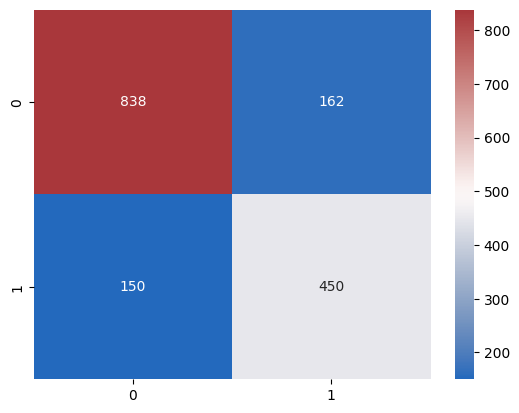

In [ ]:
sns.heatmap(cm, cmap='vlag', annot=True, fmt='.22g')

In [ ]:
tp, fn, fp, tn

(np.int64(838), np.int64(162), np.int64(150), np.int64(450))

In [ ]:
results = pd.DataFrame({
    'true': y.reset_index(drop=True),
    'pred': y_pred
})

X_test_reset = X.reset_index(drop=True)

results = pd.concat([results, X_test_reset], axis=1)

wrong = results[results['true'] != results['pred']]
print(len(wrong))

312


In [ ]:
fp = wrong[(wrong['true'] == 0) & (wrong['pred'] == 1)]
fn = wrong[(wrong['true'] == 1) & (wrong['pred'] == 0)]

In [ ]:
len(fp), len(fn)

(146, 139)

In [ ]:
fp['text_normalized'].iloc[0]

'job offer and my resumezawodny date < GPE > the business news of the day ha long been telling u that we re in a very slow economic period yet i ve received multiple job solicitation recently not random head hunter or anything people i know who know me relatively well want'

In [ ]:
fp['text_normalized']

,text_normalized
0,job offer and my resumezawodny date < GPE > th...
3,the gov get tough and yet still noone is out t...
9,aa meeting the hottest place to meet woman wit...
18,the gov get tough fair use need to be clarifie...
23,help i ve lost my exmh unseen window < PERSON ...
...,...
561,pythonanywhere confirm your email gmail comhi ...
564,< ORG > service to provide vibrator to woman w...
569,ilug retrieving read mail from webmail eircom ...
578,all digitaldiveintomark date 06t23 slashdot di...


well, some of these seem to be actually borderline spam mail, especially confirm email and

In [ ]:
fp['text_normalized'][564]

'< ORG > service to provide vibrator to woman with sexual dysfunction fark date 30t14 some dysfunctional woman'

In [ ]:
fn['text_normalized']

,text_normalized
601,your account access ha been < PERSON > mitedpa...
625,important cuna verificationcredit < ORG >
626,recipient
628,a outline none color text decoration underline...
630,important account information jpmorgan chase co
...,...
1569,a outline none color text decoration underline...
1573,the bookkeeper vassily stepanovich casandra h ...
1581,update your accountebay user
1595,new improved fat burner now with tv fat absorb...


In [ ]:
fn['text_normalized'].iloc[0]

'your account access ha been < PERSON > mitedpaypal resolution center < ORG > font family tahoma font size 12px message message message dummy message message message td font family < ORG > sans serif font size 12px color message message message font family 4 < ORG > sans serif font size 12px color message message message < PERSON > < PERSON > ne height message message message ul ppsmallborder margin 10px 5px 10px 20px message message message < PERSON > ppsmallborder < PERSON > margin 0px 0px 5px 0px message message message ul pp narrow margin 10px 5px 0px 40px message message message hr dotted width margin top 0px margin bottom 0px border left fff border right fff border top fff border bottom 2px dotted < PERSON > message message message pp label font family < ORG > sans serif font size 10px font weight bold color message message message pp serifbig font family serif font size 20px font weight bold color message message message pp serif font family serif font size 16px color message me

##logreg

In [ ]:
X_combined = X_combined.drop(columns=['avg_wordnet_depth'])

In [ ]:
y_pred = logreg.predict(X_combined.to_numpy())

In [ ]:
print("Accuracy:", accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

Accuracy: 0.845
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       600
           1       0.89      0.86      0.87      1000

    accuracy                           0.84      1600
   macro avg       0.83      0.84      0.84      1600
weighted avg       0.85      0.84      0.85      1600



lets look at all wrong ones:

In [ ]:
results = pd.DataFrame({
    'text': X['text_normalized'],
    'true': y,
    'pred': y_pred
})

wrong = results[results['true'] != results['pred']]
print(len(wrong))

248


In [ ]:
wrong

,text,true,pred
17,satalk sa and patent idea be sa in the news ju...,0,1
19,zzzzteana fw please give generouslyandy origin...,0,1
28,sf weekly s ultimate sf date < PERSON > here s...,0,1
48,same thread ish ilug adsl router < PERSON > il...,0,1
54,renew your jetbrains educational packjetbrains...,0,1
...,...,...,...
978,blablacar blablacar blablacar blablacar blabla...,1,0
982,hilarious prank call serviceuk prank call visi...,1,0
985,custom software development service available ...,1,0
988,security center advisorypaypal dummy body td f...,1,0


In [ ]:
wrong[wrong['true'] == 0]

,text,true,pred
17,satalk sa and patent idea be sa in the news ju...,0,1
19,zzzzteana fw please give generouslyandy origin...,0,1
28,sf weekly s ultimate sf date < PERSON > here s...,0,1
48,same thread ish ilug adsl router < PERSON > il...,0,1
54,renew your jetbrains educational packjetbrains...,0,1
...,...,...,...
576,whatever dude com need quick to get their free...,0,1
581,< PERSON > neighborsboingboing date not supply...,0,1
589,sell wed bliss be ouch cdale tom i agree < PER...,0,1
595,sf weekly s ultimate sf date < PERSON > weekly...,0,1


###confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y, y_pred, labels=[1, 0])
tp = cm[0, 0]
fn = cm[0, 1]
fp = cm[1, 0]
tn = cm[1, 1]

In [ ]:
import seaborn as sns

<Axes: >

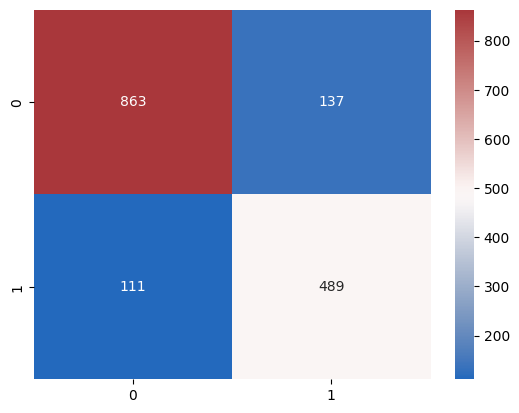

In [ ]:
sns.heatmap(cm, cmap='vlag', annot=True, fmt='.22g')

In [ ]:
tp, fn, fp, tn

(np.int64(863), np.int64(137), np.int64(111), np.int64(489))

In [ ]:
results = pd.DataFrame({
    'true': y.reset_index(drop=True),
    'pred': y_pred
})

X_test_reset = X.reset_index(drop=True)

results = pd.concat([results, X_test_reset], axis=1)

wrong = results[results['true'] != results['pred']]
print(len(wrong))

248


In [ ]:
fp = wrong[(wrong['true'] == 0) & (wrong['pred'] == 1)]
fn = wrong[(wrong['true'] == 1) & (wrong['pred'] == 0)]

In [ ]:
fp

,true,pred,file,error,text_normalized,flesch_reading_ease,avg_sentence_length,avg_wordnet_depth
17,0,1,,,satalk sa and patent idea be sa in the news ju...,-46.604851,45.333333,4.389675
19,0,1,,,zzzzteana fw please give generouslyandy origin...,-237.860063,108.666667,3.725781
28,0,1,,,sf weekly s ultimate sf date < PERSON > here s...,-93.043846,197.000000,3.712849
48,0,1,,,same thread ish ilug adsl router < PERSON > il...,-101.685562,39.600000,4.041897
54,0,1,,,renew your jetbrains educational packjetbrains...,-57.682826,47.333333,3.757059
...,...,...,...,...,...,...,...,...
576,0,1,,,whatever dude com need quick to get their free...,79.557500,16.000000,2.611508
581,0,1,,,< PERSON > neighborsboingboing date not supply...,-67.426892,156.000000,4.227179
589,0,1,,,sell wed bliss be ouch cdale tom i agree < PER...,-30.026148,128.000000,3.503098
595,0,1,,,sf weekly s ultimate sf date < PERSON > weekly...,-114.370534,208.000000,4.276024


In [ ]:
fp['text_normalized'].iloc[0]

'satalk sa and patent idea be sa in the news justin shore < PERSON > write at pm write the nature of our patent be about put a warrant mark in rfc x header or in the body to allow sender to warrant their mail a not spam and then to use copyright and trademark infringement to enable habeas to enforce that warranty why be it that i envision verisign do something like this yeah like i want verisign to sign all my spam er mail for me pay them enough and they d probably sign spam too j justin shore e s e ssr pittsburg state university network system manager this sf net email be sponsor by osdn tire of that same old cell phone get a new here for free spamassassin talk mail list'

In [ ]:
fp['text_normalized']

,text_normalized
0,job offer and my resumezawodny date < GPE > th...
3,the gov get tough and yet still noone is out t...
9,aa meeting the hottest place to meet woman wit...
18,the gov get tough fair use need to be clarifie...
23,help i ve lost my exmh unseen window < PERSON ...
...,...
561,pythonanywhere confirm your email gmail comhi ...
564,< ORG > service to provide vibrator to woman w...
569,ilug retrieving read mail from webmail eircom ...
578,all digitaldiveintomark date 06t23 slashdot di...


well, some of these seem to be actually borderline spam mail, especially confirm email and

In [ ]:
fp['text_normalized'][564]

'< ORG > service to provide vibrator to woman with sexual dysfunction fark date 30t14 some dysfunctional woman'

In [ ]:
fn['text_normalized']

,text_normalized
601,your account access ha been < PERSON > mitedpa...
625,important cuna verificationcredit < ORG >
626,recipient
628,a outline none color text decoration underline...
630,important account information jpmorgan chase co
...,...
1569,a outline none color text decoration underline...
1573,the bookkeeper vassily stepanovich casandra h ...
1581,update your accountebay user
1595,new improved fat burner now with tv fat absorb...


In [ ]:
fn['text_normalized'].iloc[0]

'your account access ha been < PERSON > mitedpaypal resolution center < ORG > font family tahoma font size 12px message message message dummy message message message td font family < ORG > sans serif font size 12px color message message message font family 4 < ORG > sans serif font size 12px color message message message < PERSON > < PERSON > ne height message message message ul ppsmallborder margin 10px 5px 10px 20px message message message < PERSON > ppsmallborder < PERSON > margin 0px 0px 5px 0px message message message ul pp narrow margin 10px 5px 0px 40px message message message hr dotted width margin top 0px margin bottom 0px border left fff border right fff border top fff border bottom 2px dotted < PERSON > message message message pp label font family < ORG > sans serif font size 10px font weight bold color message message message pp serifbig font family serif font size 20px font weight bold color message message message pp serif font family serif font size 16px color message me

# Сравнение

Я использовал:
- очистку текста - удалил ссылки, числа, названия, так как часто они не несут никакого дополнительного смысла и мешают генерализироваться модели
- подмену текста - заменил сокращения полными формами, даты и прочее на соответствующие токены
- лемматизацию - полезно иметь только корень слова, остальное часто не нужно и опять же, мешает модели обобщать

вместо tf-idf (действительно, не лучший выбор) использовал предобученную BERT для векторизации. в целом, вместо векторизации вообще можно использовать какие-то ключевые слова, их наличие или отсутствие как категориальные признаки. Проблема здесь в том, что язык богат и все их описать затруднительно.

я использовал модели, довольно классические для классификации - основанный на лесе xgboost и logreg. В целом, можно было бы еще использовать MLP или какую-то, но как показывает практика, против бустинга редко что-то выигрывает

есть вариант с помощью beautifulsoup сделать парсинг html, если тело письма это html страница. Хотя, удалив все тэги, придем к похожему варианту. Плюс, как показал анализ, наличие определенных тэгов или вообще полностью состоящее из html письмо вряд ли будет гарантировать его принадлежность к спаму, скорее даже наоборот

посмотрев FP от бустинга, увидел, что при просмотре глазами я бы сам такое письмо определил как спам, в logreg в FP попались письма, в которых используется неформальный стиль общения, культура так писать в email отмерла лет 20 назад, поэтому тоже можно опустить (хотя признаю, здесь можно и доработать)

я попробовал посмотреть, что с корреляцией фичей после векторизации и оказалось, что есть полностью коррелирующие. Для любой модели это довольно плохо, и при этом их не "убирает" VarianceThreshold. Естественно, PCA эта проблема решается, но тем не менее скор модели испортился, она перестала правильно распознавать. Выяснил, большинство строчек, где "сломалось" - бывшие html